**Loading the Model**

In [1]:
# loading the model


from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model and tokenizer
model_name = "gpt2-medium"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
# doing an example usage of the model loaded
question = "What is chess"
inputs = tokenizer(question, return_tensors="pt")
outputs = model.generate(**inputs)
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Question: {question}")
print(f"Answer: {answer}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What is chess
Answer: What is chess?

Chess is a game of strategy, where the pieces move in a certain order.


**EDA on my data**

In [3]:

import json
import os
from transformers import pipeline, GPT2Tokenizer, GPT2LMHeadModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text (this is just for the text. I will do more preprocessing in the future)
def preprocess_text(text):
    text = text.lower()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words and word.isalnum()]

    # Join the words back into a string
    text = " ".join(words)

    return text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

import json
import os
import matplotlib.pyplot as plt
import re

# this function get the text in my 'data' directory

def analyze_text_files(directory):
    """Analyzes text files in a directory."""
    word_counts = {}
    total_words = 0
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    text = f.read()
                    words = re.findall(r'\b\w+\b', text.lower())  # Extracting words
                    total_words += len(words)
                    for word in words:
                        word_counts[word] = word_counts.get(word, 0) + 1
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
    return word_counts, total_words




Number of questions: 350
Total number of words in all text files: 104494


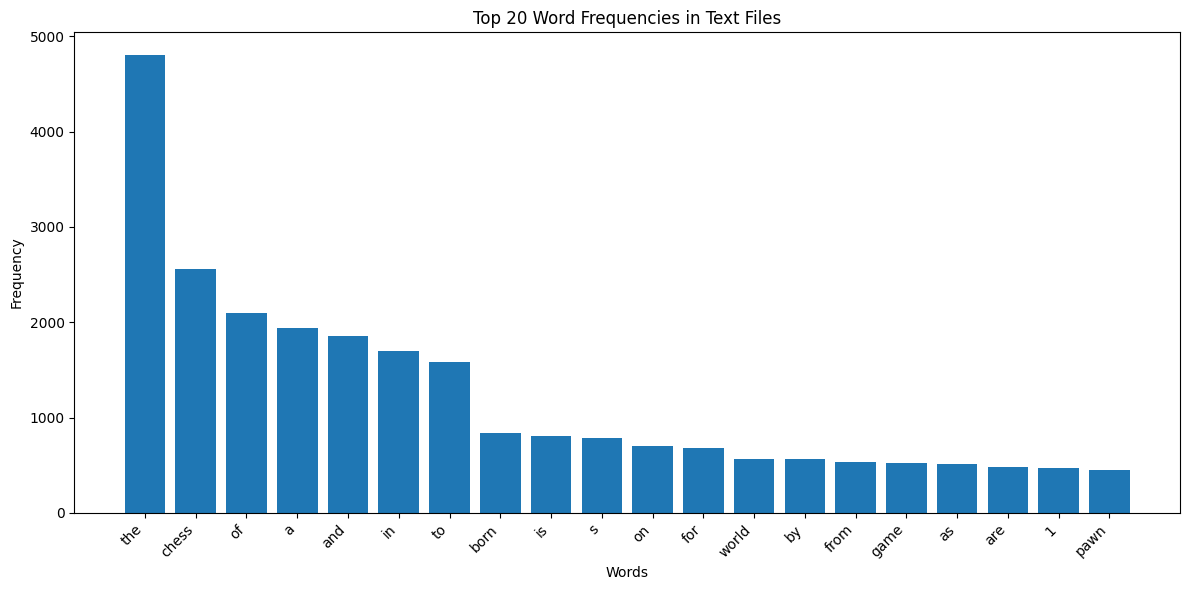

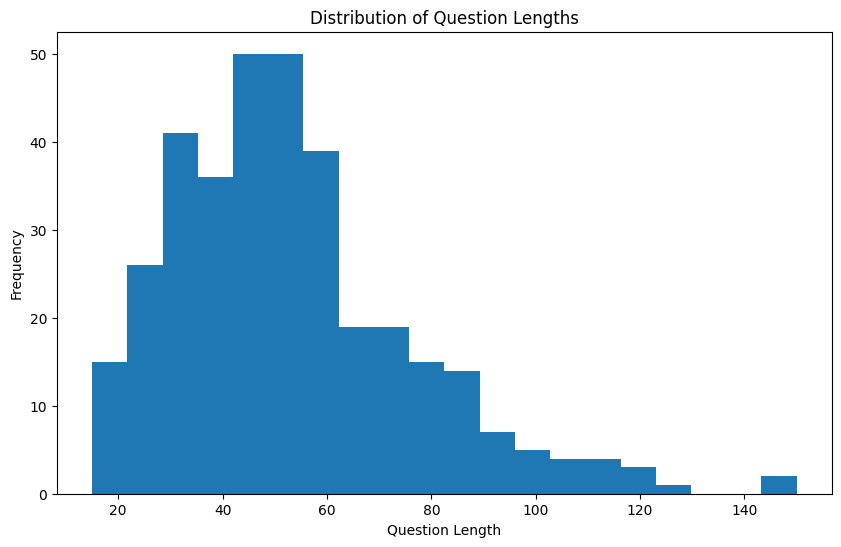

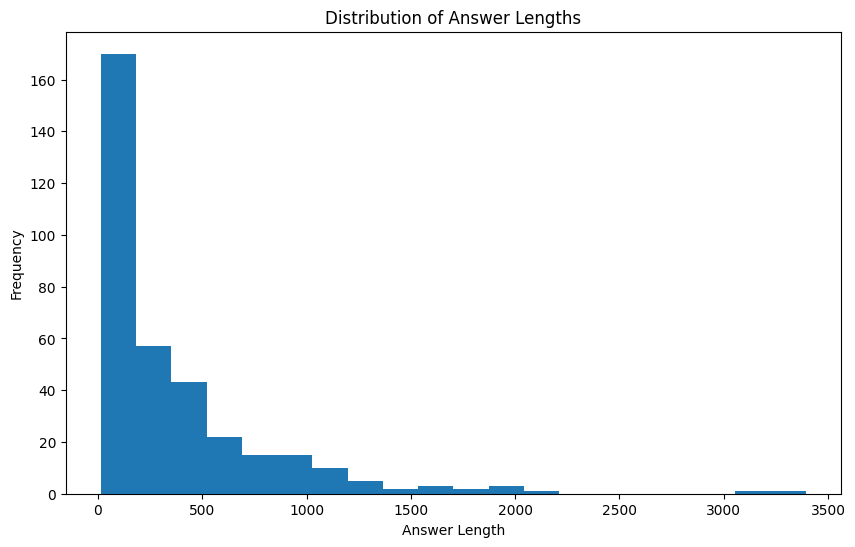

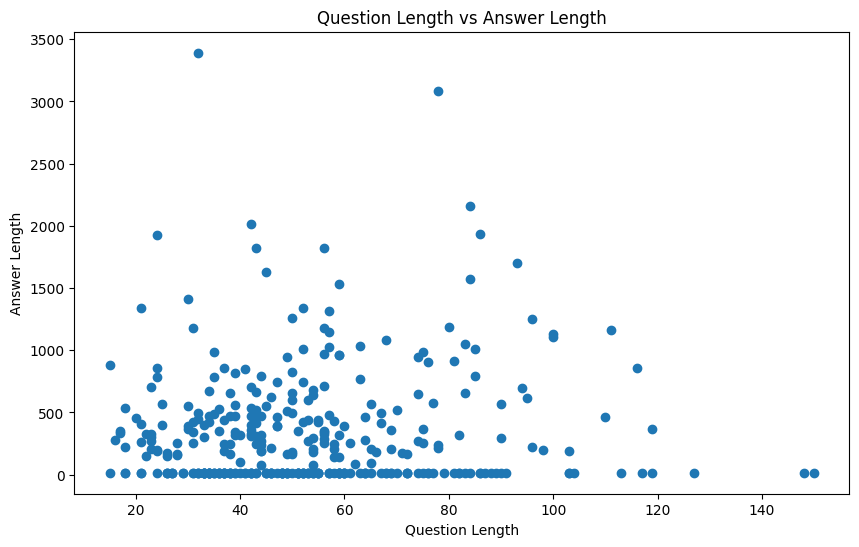

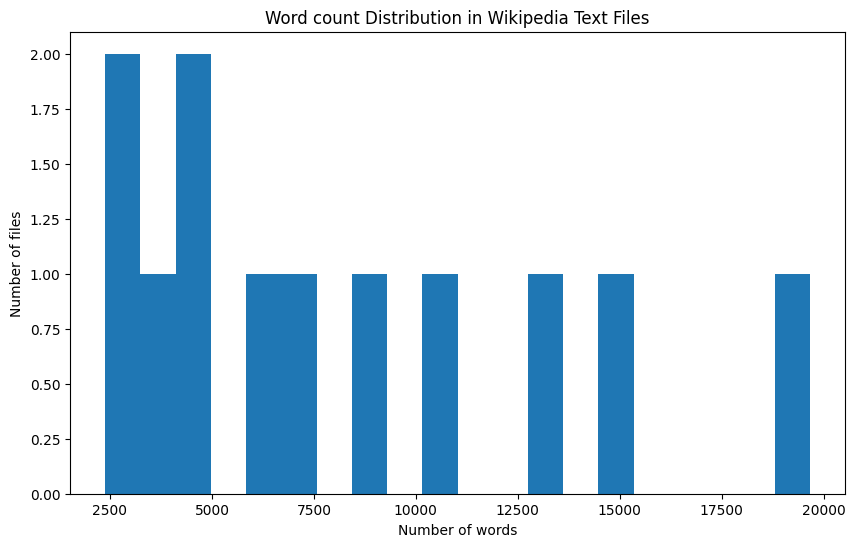

In [22]:
#plotting the graphs to checkkk my data
def plot_word_frequency(word_counts, num_words=20):
  """Plots word frequency distribution."""

  sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

  top_words = [word for word, count in sorted_counts[:num_words]]
  top_counts = [count for word, count in sorted_counts[:num_words]]

  plt.figure(figsize=(12, 6))
  plt.bar(top_words, top_counts)
  plt.xlabel("Words")
  plt.ylabel("Frequency")
  plt.title(f"Top {num_words} Word Frequencies in Text Files")
  plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.show()

try:
    with open("data/chess_com_qa.json", "r") as f:
        chess_data = json.load(f)

    # Analyze JSON data (example)
    if chess_data and isinstance(chess_data, list):
      print("Number of questions:", len(chess_data))
      # Further analysis as needed
    else:
      print("Invalid JSON data or empty file.")

except FileNotFoundError:
    print("Error: chess_com_qa.json not found.")


word_counts, total_words = analyze_text_files('data')

print(f"Total number of words in all text files: {total_words}")


plot_word_frequency(word_counts)


import matplotlib.pyplot as plt
import pandas as pd
import json
import os


# EDA for JSON data
if qa_data:
    df_qa = pd.DataFrame(qa_data)

    #Question Length Distribution
    df_qa['question_length'] = df_qa['question'].apply(len)
    plt.figure(figsize=(10, 6))
    plt.hist(df_qa['question_length'], bins=20)
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Question Length')
    plt.ylabel('Frequency')
    plt.show()


    # Answer Length Distribution
    df_qa['answer_length'] = df_qa['answer'].apply(len)
    plt.figure(figsize=(10, 6))
    plt.hist(df_qa['answer_length'], bins=20)
    plt.title('Distribution of Answer Lengths')
    plt.xlabel('Answer Length')
    plt.ylabel('Frequency')
    plt.show()


    # Scatter plot of question vs answer length
    plt.figure(figsize=(10,6))
    plt.scatter(df_qa['question_length'], df_qa['answer_length'])
    plt.title('Question Length vs Answer Length')
    plt.xlabel('Question Length')
    plt.ylabel('Answer Length')
    plt.show()

# EDA for Text Data
if wikipedia_content:
    #Word count distribution in text files
    word_counts = [len(text.split()) for text in wikipedia_content]
    plt.figure(figsize=(10,6))
    plt.hist(word_counts, bins=20)
    plt.title("Word count Distribution in Wikipedia Text Files")
    plt.xlabel("Number of words")
    plt.ylabel("Number of files")
    plt.show()



In [6]:
# Load json data
qa_data = []
try:
  with open('/content/data/chess_com_qa.json', 'r') as f:
    qa_data = json.load(f)
except FileNotFoundError:
    print("Error: '/content/data/chess_com_qa.json' not found. Please make sure the file exists in the current directory or provide the correct path.")

In [10]:
#'load wikipedia content'
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
data_dir = 'data'
wikipedia_content = []
for filename in os.listdir(data_dir):
    if filename.endswith('.txt'):
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                content = file.read()
                preprocessed_content = preprocess_text(content)
                wikipedia_content.append(preprocessed_content)
        except Exception as e:
            print(f"Error reading or processing file '{filename}': {e}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
# Trying to a question and answer from the JSON data
if qa_data:  # Check if qa_data is not empty
    question = qa_data[0].get('question', 'No question found') #safe access if key does not exist
    answer = qa_data[0].get('answer', 'No answer found')    #safe access if key does not exist
    print("Example from JSON:")
    print(f"Question: {question}")
    print(f"Answer: {answer}")

# Example: Accessing the preprocessed Wikipedia content
if wikipedia_content:
  print("\nExample from Wikipedia:")
  print(f"First Wikipedia text file content:\n{wikipedia_content[0][:200]}...") # Print the first 200 characters


Example from JSON:
Question: What is a more efficient thinking process?
Answer: I'm a bit of a perfectionist and strive to make the best move every game. As a result I think I expend too much brain power throughout the game and get burned out or overwhelmed by the possibilites, for example in the opening I would try consider all my opponents responses of which there are many in the opening, sometimes I feel habits such as these are unnecessary and are just a waste of energy. What is the most correct way to expend your mental energy in a chess game?

Example from Wikipedia:
First Wikipedia text file content:
computer program chess analysis game article part series onchess programming board representations 0x88 bitboards evaluation functions deep neural networks transformers attention efficiently updatable...


In [12]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel, AutoModelForSequenceClassification # Import AutoModelForSequenceClassification
import json
import os
import torch


# Prepare data for training (example using a simple list of text)
train_data = []
if qa_data:
    for item in qa_data:
        question = item.get('question', '')
        answer = item.get('answer', '')
        train_data.append(question + " " + answer)  # Combine question and answer as a single string

if wikipedia_content:
    train_data.extend(wikipedia_content)


In [13]:
# Tokenizing the data
# Add the padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token
train_encodings = tokenizer(train_data, truncation=True, padding=True, return_tensors='pt')


In [14]:
# Create a custom dataset
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Use input_ids as labels for language modeling
        item['labels'] = item['input_ids']
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = ChessDataset(train_encodings)


In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./chess_gpt2_results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,  # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./chess_gpt2_logs',            # directory for storing logs
    logging_steps=10,
)

# If using GPT2LMHeadModel (recommended for Q&A):
model = GPT2LMHeadModel.from_pretrained(model_name)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: begati16 (begati16-african-leadership-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<ipython-input-14-a69f6c1d33b8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,10.925600
20,9.567700
30,8.127000
40,5.824400
50,3.546900
60,2.031500
70,0.913300
80,0.432700
90,0.435200
100,0.761200


<ipython-input-14-a69f6c1d33b8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-14-a69f6c1d33b8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=1086, training_loss=0.7960894061715563, metrics={'train_runtime': 1181.726, 'train_samples_per_second': 0.919, 'train_steps_per_second': 0.919, 'total_flos': 2017137908514816.0, 'train_loss': 0.7960894061715563, 'epoch': 3.0})

In [16]:
# Save the fine-tuned model
model.save_pretrained("./chess_gpt2_fine_tuned")
tokenizer.save_pretrained("./chess_gpt2_fine_tuned")

('./chess_gpt2_fine_tuned/tokenizer_config.json',
 './chess_gpt2_fine_tuned/special_tokens_map.json',
 './chess_gpt2_fine_tuned/vocab.json',
 './chess_gpt2_fine_tuned/merges.txt',
 './chess_gpt2_fine_tuned/added_tokens.json')

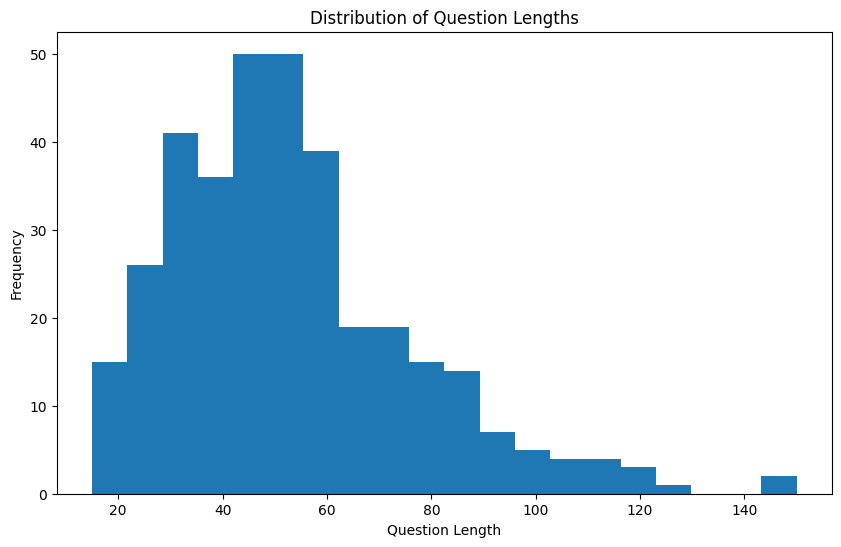

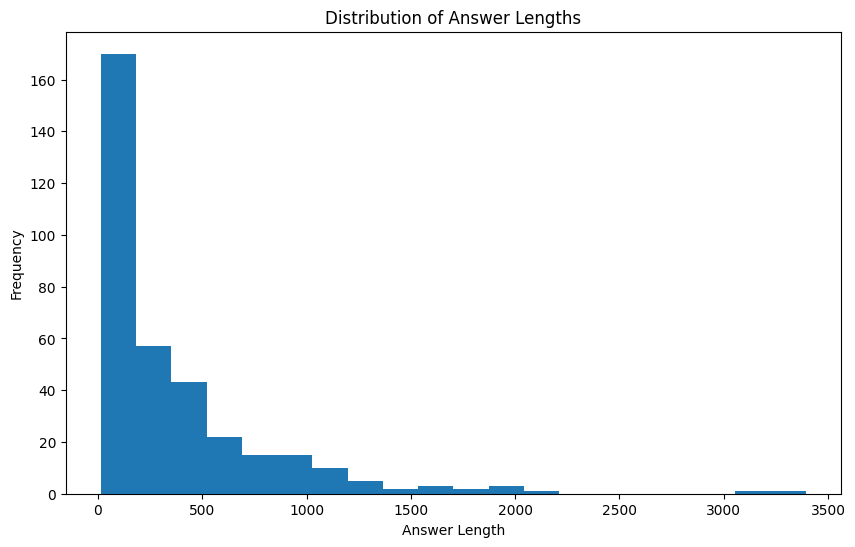

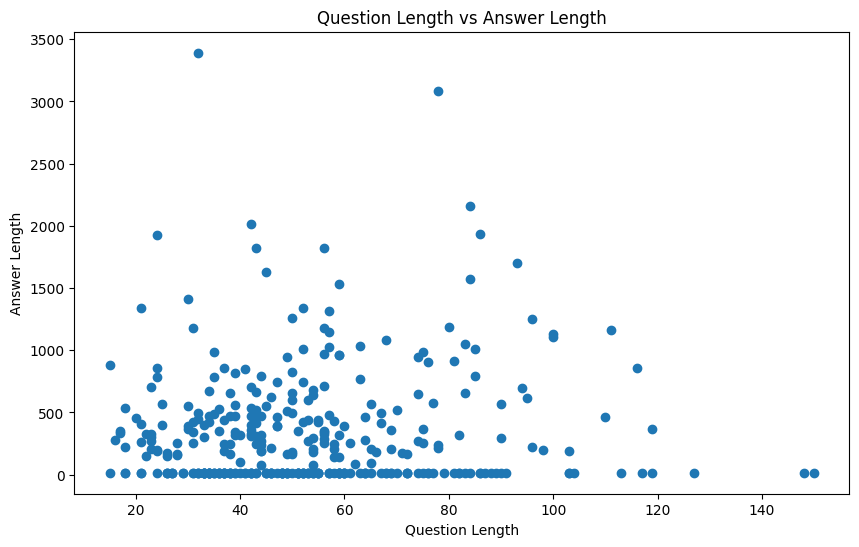

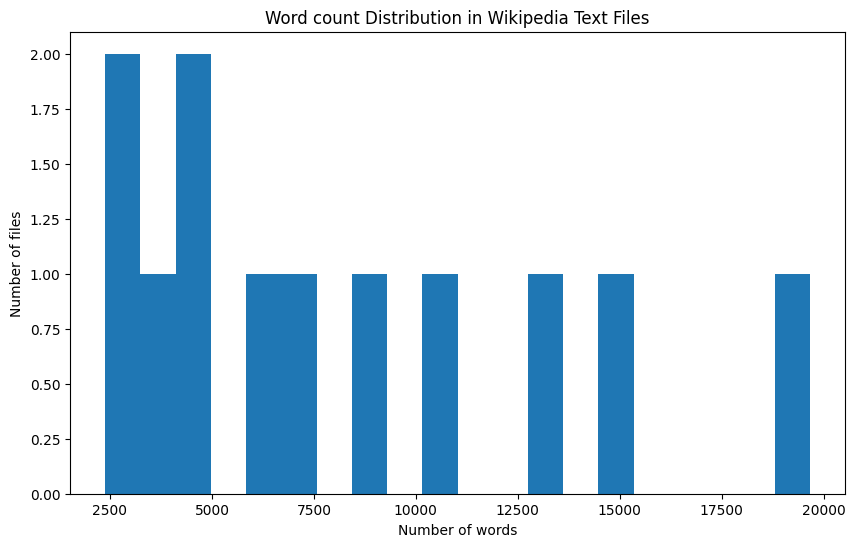

In [18]:
# prompt: evaluate the model and do an extensive eda of the data we loaded using matplotlib

import matplotlib.pyplot as plt
import pandas as pd
import json
import os


# EDA for JSON data
if qa_data:
    df_qa = pd.DataFrame(qa_data)

    #Question Length Distribution
    df_qa['question_length'] = df_qa['question'].apply(len)
    plt.figure(figsize=(10, 6))
    plt.hist(df_qa['question_length'], bins=20)
    plt.title('Distribution of Question Lengths')
    plt.xlabel('Question Length')
    plt.ylabel('Frequency')
    plt.show()


    # Answer Length Distribution
    df_qa['answer_length'] = df_qa['answer'].apply(len)
    plt.figure(figsize=(10, 6))
    plt.hist(df_qa['answer_length'], bins=20)
    plt.title('Distribution of Answer Lengths')
    plt.xlabel('Answer Length')
    plt.ylabel('Frequency')
    plt.show()


    # Scatter plot of question vs answer length
    plt.figure(figsize=(10,6))
    plt.scatter(df_qa['question_length'], df_qa['answer_length'])
    plt.title('Question Length vs Answer Length')
    plt.xlabel('Question Length')
    plt.ylabel('Answer Length')
    plt.show()

    # EDA for Text Data
    if wikipedia_content:
    # Example 4: Word count distribution in text files
    word_counts = [len(text.split()) for text in wikipedia_content]
    plt.figure(figsize=(10,6))
    plt.hist(word_counts, bins=20)
    plt.title("Word count Distribution in Wikipedia Text Files")
    plt.xlabel("Number of words")
    plt.ylabel("Number of files")
    plt.show()


